# Part 1 

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mannwhitneyu

from sklearn.neighbors import NearestNeighbors

import statsmodels.api as sm

In [3]:
df = pd.read_csv('/Users/jackfederle/Documents/python/Auto1-DA-TestData.csv', index_col='index')

A car cluster is defined by the combination of the variables “country”, “manufacturer”
and “fuel_type” (e.g., all BMWs, which have fuel_type Diesel and are sourced in the
country USA will belong to the car cluster “China | Skoda | Diesel”). Please always
use this logic to define car clusters in your analysis.

## Question 1
Name the fastest selling car cluster in the dataset and compute the average number of days that it takes to sell cars that belong in this cluster.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220885 entries, 0 to 224811
Data columns (total 8 columns):
sourcing_country    220885 non-null object
manufacturer        220885 non-null object
fuel_type           220885 non-null object
buy_price           220885 non-null int64
sales_channel       220885 non-null object
sold                220885 non-null int64
bought_date         220885 non-null object
sold_date           208319 non-null object
dtypes: int64(2), object(6)
memory usage: 15.2+ MB


In [5]:
# here a create a field name delta (in seconds) that is the difference between the bought and sold dates
df['bought_date'] = pd.to_datetime(df['bought_date'])
df['sold_date'] = pd.to_datetime(df['sold_date'])
df['delta'] = df['sold_date'] - df['bought_date']
df['delta'] = df['delta'].astype('timedelta64[s]')/ 60 / 60 /24
df.head(3)

,sourcing_country,manufacturer,fuel_type,buy_price,sales_channel,sold,bought_date,sold_date,delta
index,,,,,,,,,
0,USA,Mitsubishi,Diesel,2844,auction_type1,1,2015-04-30 11:52:02,2015-05-09 22:41:50,9.451250
1,USA,Mitsubishi,Diesel,43404,auction_type2,1,2015-05-23 15:12:53,2015-09-23 17:50:04,123.109155
2,USA,Peugeot,Diesel,18900,auction_type2,1,2015-02-25 13:15:21,2015-03-08 18:35:06,11.222049


In [6]:
df['sourcing_country'].value_counts()

USA      162079
China     58806
Name: sourcing_country, dtype: int64

In [7]:
print(len(df['manufacturer'].value_counts()))

29


In [8]:
df['fuel_type'].value_counts()

Diesel    220885
Name: fuel_type, dtype: int64

Interesting to notice that all cars in this dataset are Diesel, from here on, I will focus solely on the sourcing country and the manufacturer 

In [9]:
df['sold'].value_counts()

1    208319
0     12566
Name: sold, dtype: int64

In [10]:
# Here I group by sourcing country and manufacter so to have the clusters, I average the delta and sort the resulting dataframe
q1 = df.groupby(['sourcing_country', 'manufacturer'])['delta'].mean()
q1 = q1.reset_index(drop=False)
q1 = q1.sort_values(by = 'delta', ascending = True)
q1.head(1)

,sourcing_country,manufacturer,delta
50,USA,Skoda,16.253453


The fastest selling cluster is Diesel | Skoda | USA with an average delta of 16.25 days days

## Question 2 

Is the cluster that you identified under 1a) selling significantly faster than the
“USA | Maserati | Diesel” cluster? Please explain how you reached this conclusion.

As first step I take a look at the distributions and at the means. Then I will decide how to proceed 

In [221]:
q1.loc[q1['manufacturer'] == 'Maserati']

,sourcing_country,manufacturer,delta
39,USA,Maserati,2.051806e+06
10,China,Maserati,2.882262e+06


1404298.3176470587 2239024.014594588


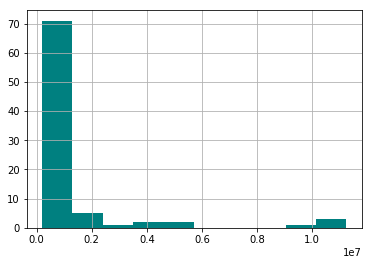

In [222]:
skoda = df.loc[df['manufacturer'] == 'Skoda']
skoda = skoda.loc[skoda['sourcing_country'] == 'USA']
skoda['delta'].hist(color = 'teal')
print(skoda['delta'].mean(), skoda['delta'].std())

### Log transformation 

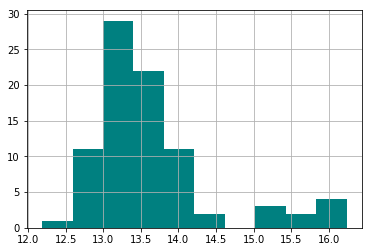

In [223]:
log_skoda = np.log(skoda['delta'] + 1)
log_skoda.hist(color = 'teal')

In [224]:
print('Mean: %.2f, median: %.2f' % (log_skoda.mean(), log_skoda.median()))

Mean: 13.66, median: 13.45


I cannot assume normality. I tried to normalize the data with a logarithmic transformation but I was not too happy with the outcome. 

2051806.4359203093 2784138.6825338057


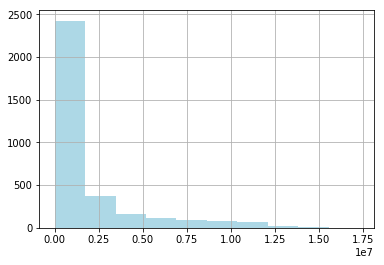

In [225]:
maserati = df.loc[df['manufacturer'] == 'Maserati']
maserati = maserati.loc[maserati['sourcing_country'] == 'USA']
maserati['delta'].hist(color = 'lightblue')
print(maserati['delta'].mean(), maserati['delta'].std())

As for Skoda, the Maserati distribution is not normal. To compare the two **MEDIANS** and verify if the difference is significant, I will use a non parametric test, the Mann Whitney U test

In [226]:
stat1, p = mannwhitneyu(maserati['delta'], skoda['delta'])
print('test statistics = %.3f, p = %.3f' % (stat1, p))

alpha = 0.05
if p > alpha:
    print('difference not significant')
else:
    print('difference is significant')

test statistics = 124609.000, p = 0.001
difference is significant


With samples this large, the value of U approaches a normal distribution. It is possible to test our hypothesis with a z-test 

In [227]:
def z (stat, sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    stdev = np.sqrt((n1 * n2 * (n1 + n2 + 1))/12)
    z = (stat - (n1 * n2)/ 2)/ stdev
    return z

In [228]:
z(stat1, maserati['delta'], skoda['delta'])

-2.9934073469682203

In [229]:
print('Maserati delta %.2f, Skoda delta %2f' % (maserati['delta'].median()/ 60 / 60 /24, skoda['delta'].median()/ 60 / 60 /24))

Maserati delta 10.98, Skoda delta 8.057303


### Question 3 

In order to measure the sale speed of different car clusters, let’s focus on a KPI that captures the percentage of cars that are sold within 100 days. Name the car cluster that performs worst in terms of this KPI. Please comment briefly on any additional calculations that you might have to come up with the solution. 

In [230]:
df.head(2)

,sourcing_country,manufacturer,fuel_type,buy_price,sales_channel,sold,bought_date,sold_date,delta
index,,,,,,,,,
0,USA,Mitsubishi,Diesel,2844,auction_type1,1,2015-04-30 11:52:02,2015-05-09 22:41:50,816588.0
1,USA,Mitsubishi,Diesel,43404,auction_type2,1,2015-05-23 15:12:53,2015-09-23 17:50:04,10636631.0


In [231]:
benchmark = 100 * 24 * 60 * 60 # seconds in 100 days
df['within100'] = df['delta'] < benchmark
df3 = df.groupby(['sourcing_country', 'manufacturer']).sum()
df3['KPI'] = df3['within100']/df3['sold']
df3 = df3.sort_values(by = 'KPI')
df3.head(1)

,,buy_price,sold,delta,within100,KPI
sourcing_country,manufacturer,,,,,
China,Tata,244581,28,124059354.0,21.0,0.75


Now I want to see which is the cluster that sells the least

In [232]:
df4 = df.groupby(['sourcing_country', 'manufacturer'])['buy_price', 'within100'].agg(['sum', 'count'])
df4['KPI2'] = df4.xs(('within100', 'sum'), axis = 1)/df4.xs(('buy_price', 'count'), axis = 1)
df4 = df4.sort_values(by = 'KPI2')
df4.head(1)

buy_price       within100            KPI2
                                    sum count       sum count          
sourcing_country manufacturer                                          
China            Mitsubishi    65926653  2636     983.0  2636  0.372914

# Part 2 

## Question 1
Our company currently uses different channels to sell cars. The different sales channels are named "auction_type1" and "auction_type2" in the provided dataset. Can you find out whether selling cars through auction_type1 causes a decrease in the sale speed (compared to selling cars through auction_type2)?

In [233]:
df.groupby('sales_channel')['delta'].mean()

sales_channel
auction_type1    2.220783e+06
auction_type2    2.599180e+06
Name: delta, dtype: float64

In [234]:
df.groupby('sales_channel')['delta'].median()

sales_channel
auction_type1     802411.0
auction_type2    1132744.0
Name: delta, dtype: float64

In [235]:
df.groupby('sales_channel')['buy_price'].mean()

sales_channel
auction_type1     5797.374665
auction_type2    24397.416025
Name: buy_price, dtype: float64

In [236]:
df.groupby('sales_channel')['sold'].count()

sales_channel
auction_type1    110584
auction_type2    110301
Name: sold, dtype: int64

While the number of cars sold through each channel is comparable, there is clearly a difference in speed and price 

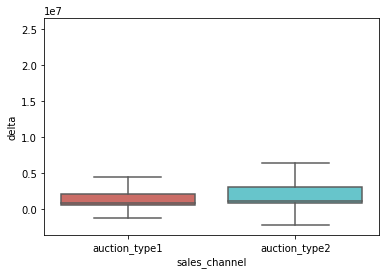

In [237]:
ax = sns.boxplot(y="delta", x="sales_channel", data=df, palette = 'hls', fliersize = False)

In [238]:
t1 = df[df['sales_channel'] == 'auction_type1']
t2 = df[df['sales_channel'] == 'auction_type2']

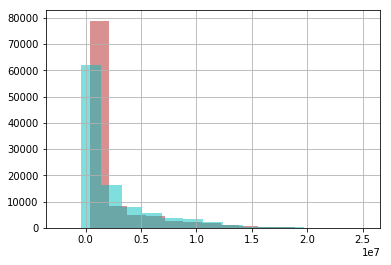

In [239]:
t1['delta'].hist(alpha = 0.5, bins = 15, color = 'firebrick')
t2['delta'].hist(alpha = 0.5, bins = 15, color = 'c')

In [240]:
print('Median of auction type 1 %.2f, median of auctrion type 2 %.2f' % (t1['delta'].median(), t2['delta'].median()))

Median of auction type 1 802411.00, median of auctrion type 2 1132744.00


The two distributions are again not normal, so I will relay on the same test as before

In [241]:
stat2, p = mannwhitneyu(t1['delta'], t2['delta'])
print('test statistics = %.3f, p = %.3f' % (stat2, p))

alpha = 0.05
if p > alpha:
    print('difference not significant')
else:
    print('difference is significant')

test statistics = 5236511026.000, p = 0.000
difference is significant


In [242]:
z(stat2, t1['delta'], t2['delta'])

-57.54462949431563

The difference between the two medians is significant, however at this point it is not clear whether the auction type is the cause of the difference, of if cheaper cars sell faster. Next I will control for the price variable and verify how big of a factor the auction type is. To be finished. 